In [1]:
import gc
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
data_src = "../data"
data_dir = pathlib.Path(data_src) / "resisc45"

classes = os.listdir(data_dir)
num_classes = len(classes)
print(f"Total number of classes: {num_classes}")
print(classes)

Total number of classes: 44
['cloud', 'baseball', 'beach', 'forest', 'stadium', 'parking', 'mobile', 'snowberg', 'church', 'runway', 'golf', 'airplane', 'desert', 'ground', 'river', 'island', 'roundabout', 'harbor', 'bridge', 'freeway', 'intersection', 'industrial', 'rectangular', 'sea', 'tennis', 'meadow', 'terrace', 'thermal', 'airport', 'palace', 'medium', 'mountain', 'basketball', 'chaparral', 'railway', 'lake', 'commercial', 'storage', 'circular', 'dense', 'ship', 'wetland', 'overpass', 'sparse']


In [3]:
num_to_label = {}
label_to_num = {}
for i, c in enumerate(classes):
    num_to_label[i] = c
    label_to_num[c] = i

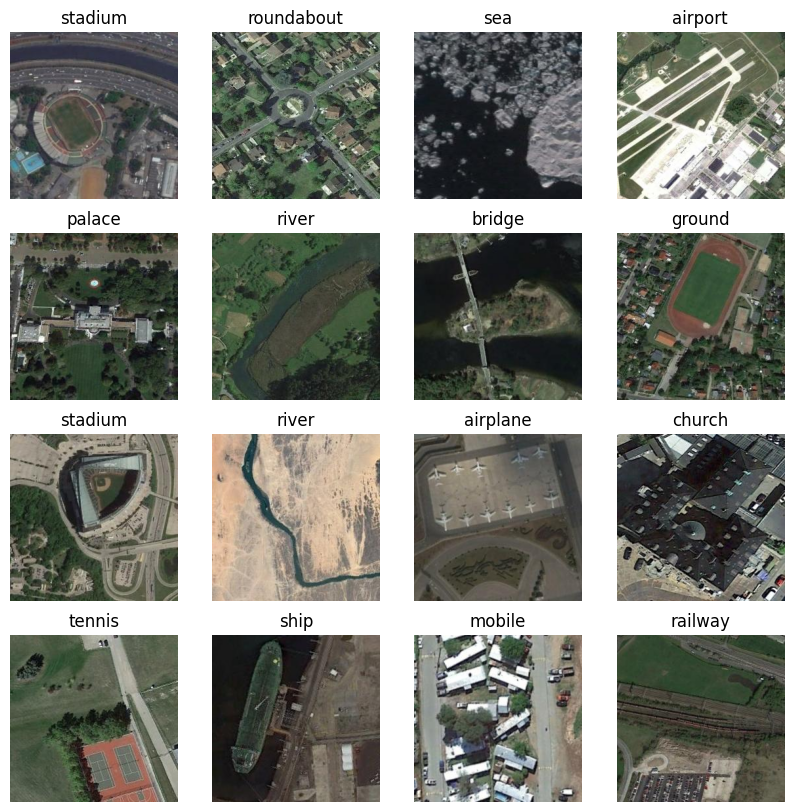

In [4]:
class Resisc45Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = os.listdir(data_dir)
        self.num_classes = len(self.classes)
        self.images = []
        self.labels = []
        for c in self.classes:
            class_dir = data_dir / c
            for image_path in class_dir.glob("*.jpg"):
                self.images.append(image_path)
                self.labels.append(label_to_num[c])

    def get_image_size(self):
        image_path = self.images[0]
        image = plt.imread(image_path)
        return image.shape

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = plt.imread(image_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def plot_example_images(dataset: Dataset, n: int = 16):
    # take random n samples from dataset
    images, labels = zip(*[dataset[i] for i in np.random.choice(len(dataset), n)])
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    for i, image in enumerate(images):
        label = num_to_label[labels[i]]
        ax[i // 4, i % 4].imshow(image)
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
    plt.show()

dataset = Resisc45Dataset(data_dir)


len(np.unique(dataset.labels))
plot_example_images(dataset)

## Dataloader test

train a small model on single batch to confirm everything is working

In [5]:
class TestNetwork(nn.Module):
    def __init__(self, image_size, batch_size, num_channels, num_classes):
        super().__init__()
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_channels = num_channels
        self.num_classes = num_classes

        self.first_layer = nn.Conv2d(self.num_channels, 32, kernel_size=3, padding=1)
        self.second_layer = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.last_layer = nn.Linear(64 * self.image_size[0] * self.image_size[1], self.num_classes)

    def forward(self, x):
        
        x = self.first_layer(x)
        x = nn.ReLU()(x)
        x = self.second_layer(x)
        x = nn.ReLU()(x)
        x = nn.Flatten()(x)
        x = self.last_layer(x)
        return x
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

In [13]:
def transform_ncwh(image_tensor):
    return image_tensor.permute(0, 1, 2)

dataset = Resisc45Dataset(data_dir, transform=transforms.Compose([transforms.ToTensor(), transform_ncwh]))
epochs = 5
batch_size = 32*5
image_size = dataset.get_image_size()
num_channels = image_size[2]
num_classes = dataset.num_classes

device = "cpu"

print(f"Image size: {image_size}")
print(f"Number of channels: {num_channels}")

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = TestNetwork(image_size, batch_size, num_channels, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

single_batch = next(iter(dataloader))
for epoch in range(epochs):
    # we overfit over a single batch
    images, labels = single_batch
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    logits = model(images)
    loss = F.cross_entropy(logits, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item()}, accuracy: {torch.mean((torch.argmax(logits, dim=1) == labels).float())}")

Image size: (256, 256, 3)
Number of channels: 3
Epoch: 0, Loss: 3.7843308448791504, accuracy: 0.0062500000931322575
Epoch: 1, Loss: 90.90731811523438, accuracy: 0.16875000298023224
Epoch: 2, Loss: 110.89398193359375, accuracy: 0.0625
Epoch: 3, Loss: 94.11287689208984, accuracy: 0.09375
Epoch: 4, Loss: 69.23814392089844, accuracy: 0.13750000298023224


Predictions:  [37 36 38 29 15]
Labels:  [31 17 12 18 23]


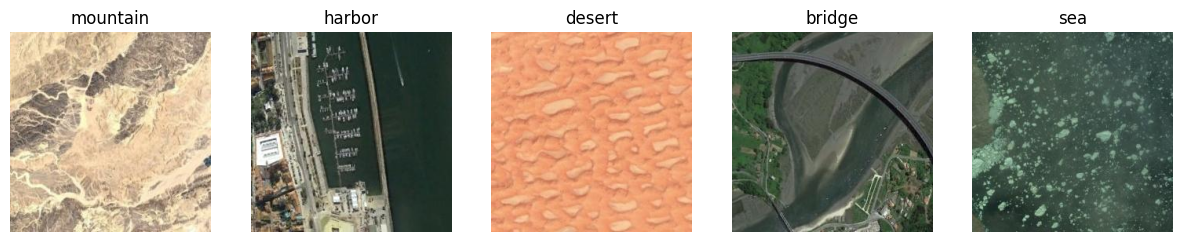

In [14]:
# take first batch
images, labels = next(iter(dataloader))

model.eval()
# get predictions for 5 images from this batch
predictions = model.predict(images[:5].to(device))
print("Predictions: ", np.argmax(predictions.cpu().detach().numpy(), axis=1))
print("Labels: ", labels[:5].numpy())

# show images
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
for i, image in enumerate(images[:5]):
    ax[i].imshow(image.permute(1, 2, 0))
    ax[i].axis("off")
    label = num_to_label[labels[i].item()]
    ax[i].set_title(label)
plt.show()
